In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import make_low_rank_matrix, make_blobs
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

## Create two different test matrices

Text(0.5,1,'Matrix 2 ')

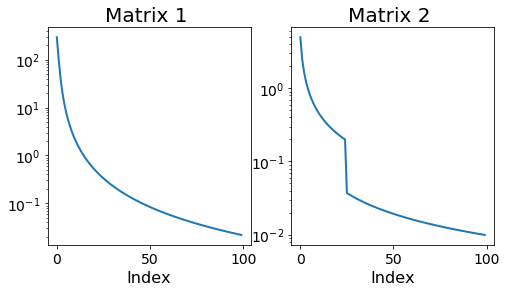

In [2]:
# Matrix 1
n = 512
x = np.linspace(0,1,n)
X,Y = np.meshgrid(x,x)

A = np.exp(-np.abs(X-Y)/0.5)


# Matrix 2
n = 512
r = 25
e = np.arange(1,r+1)
s = np.arange(r+2,n)
svs = np.hstack((5./e,1./s))
B = np.diag(svs)

f, (ax1,ax2) = plt.subplots(1, 2, figsize = (8,4))
u,sa,vh = np.linalg.svd(A)
u,sb,vh = np.linalg.svd(B)
ax1.semilogy(sa[:100], '-', linewidth = 2.0)
ax1.set_xlabel('Index', fontsize = 16)
ax1.set_title('Matrix 1 ', fontsize = 20)
ax2.semilogy(sb[:100], '-', linewidth = 2.0)
ax2.set_xlabel('Index', fontsize = 16)
ax2.set_title('Matrix 2 ', fontsize = 20)

# 1.  Accuracy of the randomized range finder

In [3]:
def computebounds(A,s,vh,k,p):
    """
    To investigate the accuracy of the bounds
    ||A - QQ'A||^2 <= ||\Sigma||^2 + ||\Sigma\Omega_2\Omega_1^+||^2. 
    
    No truncation step!
    
    """
    #Compute the error 
    n = A.shape[1]
    Omega = np.random.randn(n,k+p)
    Y   = np.dot(A,Omega)
    q,r = np.linalg.qr(Y, mode = 'reduced')
    Ah  = np.dot(q,np.dot(q.T,A))
    
    err = np.array([np.linalg.norm(A-Ah,2), np.linalg.norm(A-Ah)])
    
    
    #Compute the bounds
    Omega1 = np.dot(vh[:k,:],Omega)
    Omega2 = np.dot(vh[k:,:],Omega)
    
    Z = np.dot(np.dot(np.diag(s[k:]),Omega2), np.linalg.pinv(Omega1))
    
    #
    bnds = s[k]**2. + np.linalg.norm(Z,2)**2.
    bndf = np.sum(s[k:]**2.) +  np.linalg.norm(Z)**2.
    bounds = np.sqrt(np.array([bnds,bndf]))
    
    
    return err, bounds

### Compute the error for Matrix 1

In [4]:
u,s,vh = np.linalg.svd(A, full_matrices = False)
Anrm = np.sqrt(np.sum(s**2.))

klst = range(5,100,5)
n = len(klst)
#Error and bounds in the 2 and Frobenius norm
err_rsvd = np.zeros((n,2), dtype = 'd')
err_bnd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    error, bounds = computebounds(A,s,vh,k,p = 20)
    
    #2-norm
    err_rsvd[i,0] = error[0] 
    err_bnd[i,0]  = bounds[0]
    
    #Frobenius norm
    err_rsvd[i,1] = error[1]
    err_bnd[i,1] = bounds[1]


Text(0.5,1,'Frobenius-norm ')

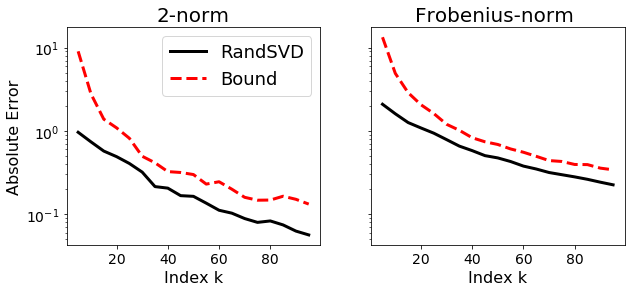

In [5]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy( klst,err_rsvd[:,0], 'k-', klst, err_bnd[:,0], 'r--', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Absolute Error', fontsize = 16)
ax1.legend({'RandSVD', 'Bound'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy( klst,err_rsvd[:,1], 'k-', klst, err_bnd[:,1], 'r--', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

### Repeat experiment for matrix 2

In [6]:
u,s,vh = np.linalg.svd(B, full_matrices = False)

klst = range(5,100,5)
n = len(klst)
#Error and bounds in the 2 and Frobenius norm
err_rsvd = np.zeros((n,2), dtype = 'd')
err_bnd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    error, bounds = computebounds(B,s,vh,k,p = 20)
    
    #2-norm
    err_rsvd[i,0] = error[0] 
    err_bnd[i,0]  = bounds[0]
    
    #Frobenius norm
    err_rsvd[i,1] = error[1]
    err_bnd[i,1] = bounds[1]


Text(0.5,1,'Frobenius-norm ')

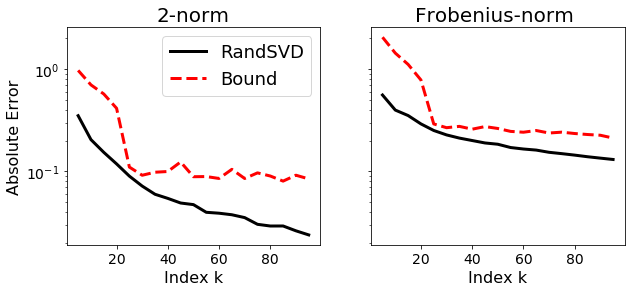

In [7]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy( klst,err_rsvd[:,0], 'k-', klst, err_bnd[:,0], 'r--', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Absolute Error', fontsize = 16)
ax1.legend({'RandSVD', 'Bound'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy( klst,err_rsvd[:,1], 'k-', klst, err_bnd[:,1], 'r--', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

# 2. Effect of the truncation step on the accuracy

In [8]:
def computebounds_trunc(A,s,vh,k,p):
    """
    To investigate the accuracy of the bounds
    ||A - QB_k||^2 <= ||\Sigma||^2 + ||\Sigma\Omega_2\Omega_1^+||_F^2. 

    
    """
    #Compute the error 
    n = A.shape[1]
    Omega = np.random.randn(n,k+p)
    Y   = np.dot(A,Omega)
    q,r = np.linalg.qr(Y, mode = 'reduced')
    B = np.dot(q.T,A)

    #truncate B
    ub,sb,vbh = np.linalg.svd(B, full_matrices = False)
    Bk = np.dot(ub[:,:k],np.dot(np.diag(sb[:k]),vbh[:k,:]))
    
    Ah  = np.dot(q,Bk)

    err = np.array([np.linalg.norm(A-Ah,2), np.linalg.norm(A-Ah)])
    
    
    #Compute the bounds
    Omega1 = np.dot(vh[:k,:],Omega)
    Omega2 = np.dot(vh[k:,:],Omega)
    
    Z = np.dot(np.dot(np.diag(s[k:]),Omega2), np.linalg.pinv(Omega1))
    
    #
    bnds = s[k]**2. + np.linalg.norm(Z)**2.
    bndf = np.sum(s[k:]**2.) +  np.linalg.norm(Z)**2.
    bounds = np.sqrt(np.array([bnds,bndf]))
    
    
    return err, bounds

### Matrix 1

In [9]:
u,s,vh = np.linalg.svd(A, full_matrices = False)
Anrm = np.sqrt(np.sum(s**2.))

klst = range(5,100,5)
n = len(klst)
#Error and bounds in the 2 and Frobenius norm
err_rsvd = np.zeros((n,2), dtype = 'd')
err_bnd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    error, bounds = computebounds_trunc(A,s,vh,k,p = 20)
    
    #2-norm
    err_rsvd[i,0] = error[0] 
    err_bnd[i,0]  = bounds[0]
    
    #Frobenius norm
    err_rsvd[i,1] = error[1]
    err_bnd[i,1] = bounds[1]

Text(0.5,1,'Frobenius-norm ')

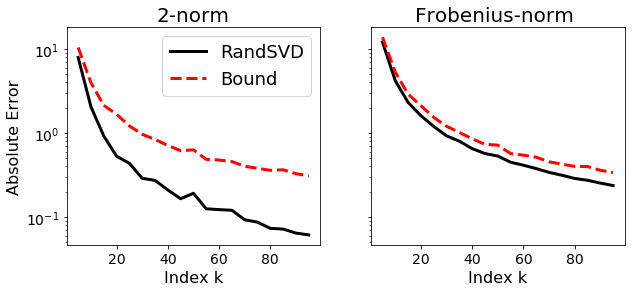

In [10]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy( klst,err_rsvd[:,0], 'k-', klst, err_bnd[:,0], 'r--', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Absolute Error', fontsize = 16)
ax1.legend({'RandSVD', 'Bound'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy( klst,err_rsvd[:,1], 'k-', klst, err_bnd[:,1], 'r--', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

### Repeat experiment for matrix 2

In [11]:
u,s,vh = np.linalg.svd(B, full_matrices = False)

klst = range(5,100,5)
n = len(klst)
#Error and bounds in the 2 and Frobenius norm
err_rsvd = np.zeros((n,2), dtype = 'd')
err_bnd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    error, bounds = computebounds_trunc(B,s,vh,k,p = 20)
    
    #2-norm
    err_rsvd[i,0] = error[0] 
    err_bnd[i,0]  = bounds[0]
    
    #Frobenius norm
    err_rsvd[i,1] = error[1]
    err_bnd[i,1] = bounds[1]

Text(0.5,1,'Frobenius-norm ')

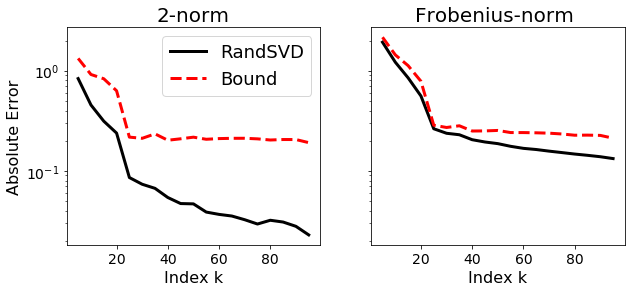

In [12]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy( klst,err_rsvd[:,0], 'k-', klst, err_bnd[:,0], 'r--', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Absolute Error', fontsize = 16)
ax1.legend({'RandSVD', 'Bound'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy( klst,err_rsvd[:,1], 'k-', klst, err_bnd[:,1], 'r--', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

# 3. Accuracy of the singular values

In [13]:
def svbounds(A,s,vh,k,p):
    """
    To investigate the accuracy of the bounds
    
    s_j(A) => s_j(QQ'A ) => s_j(A)/sqrt(1+Z**2)
    
    """
    #Compute the error 
    n = A.shape[1]
    
    Omega = np.random.randn(n,k+p)
    Y   = np.dot(A,Omega)
    q,_ = np.linalg.qr(Y, mode = 'reduced')
    B = np.dot(q.T,A)
    
    sh = np.linalg.svd(B, compute_uv = False)
    
    
    #Compute the bounds
    Omega1 = np.dot(vh[:k,:],Omega)
    Omega2 = np.dot(vh[k:,:],Omega)
    
    
    gamma = s[k]/s[:k]
    Z = np.dot(Omega2, np.linalg.pinv(Omega1))
    Znrm = np.linalg.norm(Z,2)
    
    # upper and lower bounds
    upper = s[:k]
    lower = s[:k]/np.sqrt(1+ (gamma*Znrm)**2.)
    
    return sh[:k], upper, lower

## Plot the singular values and the bounds

Text(0.5,1,'Matrix 2')

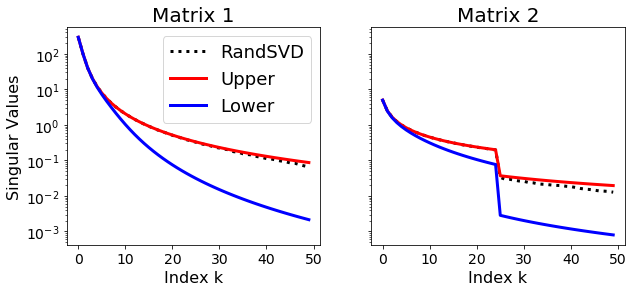

In [14]:
u,s,vh = np.linalg.svd(A, full_matrices = False)
sha, ua, la = svbounds(A,s,vh,50,10)

u,s,vh = np.linalg.svd(B, full_matrices = False)
shb, ub, lb = svbounds(B,s,vh,50,10)

ind = range(50)
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy(ind,sha, 'k:', ind, ua, 'r-', ind, la, 'b-', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Singular Values', fontsize = 16)
ax1.legend(('RandSVD', 'Upper', 'Lower'), fontsize = 18)
ax1.set_title('Matrix 1', fontsize = 20)

ax2.semilogy(ind,shb, 'k:', ind, ub, 'r-', ind, lb, 'b-', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)

ax2.set_title('Matrix 2', fontsize = 20)

# 4.  Bounds in expectation 

In [15]:
def probbounds(A,s,vh,k,p):
    """
    To investigate the accuracy of the bounds
    E ||A - QB_k||^2 <= (||\Sigma||^2 + k/(p-1)||\Sigma||_F^2)^{1/2}. 

    """
    #Compute the error 
    n = A.shape[1]
    Omega = np.random.randn(n,k+p)
    Y   = np.dot(A,Omega)
    q,r = np.linalg.qr(Y, mode = 'reduced')
    B = np.dot(q.T,A)

    #truncate B
    ub,sb,vbh = np.linalg.svd(B, full_matrices = False)
    Bk = np.dot(ub[:,:k],np.dot(np.diag(sb[:k]),vbh[:k,:]))
    
    Ah  = np.dot(q,Bk)

    err = np.array([np.linalg.norm(A-Ah,2), np.linalg.norm(A-Ah)])
    
    
    #Compute the bounds
    Omega1 = np.dot(vh[:k,:],Omega)
    Omega2 = np.dot(vh[k:,:],Omega)
    
    Z = np.dot(np.dot(np.diag(s[k:]),Omega2), np.linalg.pinv(Omega1))
    
    #
    fact = k/(p-1)
    bnds = s[k]**2. + fact*np.sum(s[k:]**2.)
    bndf = (1+fact)*np.sum(s[k:]**2.) 
    bounds = np.sqrt(np.array([bnds,bndf]))
    
    
    return err, bounds

### Matrix 1

In [16]:
u,s,vh = np.linalg.svd(A, full_matrices = False)
Anrm = np.sqrt(np.sum(s**2.))

klst = range(5,100,5)
n = len(klst)
#Error and bounds in the 2 and Frobenius norm
err_rsvd = np.zeros((n,2), dtype = 'd')
err_bnd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    error, bounds = probbounds(A,s,vh,k,p = 20)
    
    #2-norm
    err_rsvd[i,0] = error[0] 
    err_bnd[i,0]  = bounds[0]
    
    #Frobenius norm
    err_rsvd[i,1] = error[1]
    err_bnd[i,1] = bounds[1]

Text(0.5,1,'Frobenius-norm ')

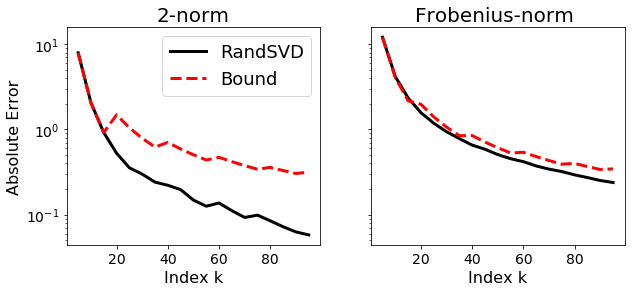

In [17]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy( klst,err_rsvd[:,0], 'k-', klst, err_bnd[:,0], 'r--', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Absolute Error', fontsize = 16)
ax1.legend({'RandSVD', 'Bound'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy( klst,err_rsvd[:,1], 'k-', klst, err_bnd[:,1], 'r--', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

### Matrix 2

In [18]:
u,s,vh = np.linalg.svd(B, full_matrices = False)

klst = range(5,100,5)
n = len(klst)
#Error and bounds in the 2 and Frobenius norm
err_rsvd = np.zeros((n,2), dtype = 'd')
err_bnd = np.zeros((n,2), dtype = 'd')
for k,i in zip(klst,range(n)):
    error, bounds = probbounds(B,s,vh,k,p = 20)
    
    #2-norm
    err_rsvd[i,0] = error[0] 
    err_bnd[i,0]  = bounds[0]
    
    #Frobenius norm
    err_rsvd[i,1] = error[1]
    err_bnd[i,1] = bounds[1]

Text(0.5,1,'Frobenius-norm ')

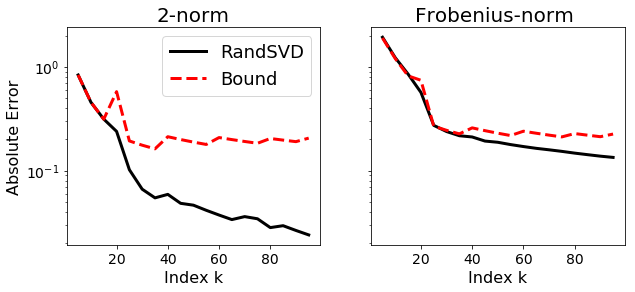

In [19]:
# plot the errors
f, (ax1,ax2) = plt.subplots(1,2,sharey = True, figsize=(10,4))
ax1.semilogy( klst,err_rsvd[:,0], 'k-', klst, err_bnd[:,0], 'r--', linewidth = 3.0)
ax1.set_xlabel('Index k', fontsize = 16)
ax1.set_ylabel('Absolute Error', fontsize = 16)
ax1.legend({'RandSVD', 'Bound'}, fontsize = 18)
ax1.set_title('2-norm', fontsize = 20)

ax2.semilogy( klst,err_rsvd[:,1], 'k-', klst, err_bnd[:,1], 'r--', linewidth = 3.0)
ax2.set_xlabel('Index k', fontsize = 16)
ax2.set_title('Frobenius-norm ', fontsize = 20)

# 5. Empirical performance

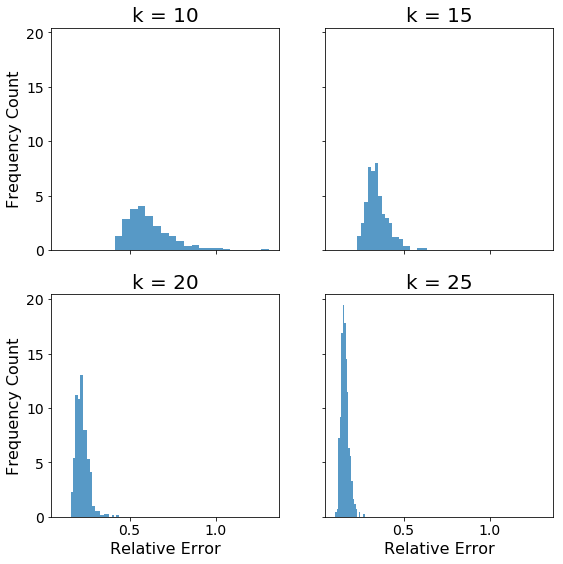

In [26]:
nsamples = 500
klst = [10,15,20,25]

def randsvd(A, k, p = 20):
    m,n = A.shape
    # Draw random matrix
    Omega = np.random.randn(n, k+p)
    
    #1. Randomized range finder
    Y = np.dot(A,Omega)
    q,r = np.linalg.qr(Y, mode = 'reduced')
    
    #2. Compute truncated SVD
    B = np.dot(q.T,A)
    u,s,vh = np.linalg.svd(B, full_matrices = False)
    u = np.dot(q,u[:,:k])
    
    return u,s[:k],vh[:k,:]

f, axarray = plt.subplots(2,2, sharex = True, sharey = True, figsize=(9,9))
for k, ax, j in zip(klst,axarray.flatten(),range(4)):
    err_rsvd = np.zeros((nsamples,), dtype = 'd')
    
    for i in range(nsamples):
        ur,sr,vrh = randsvd(A, k, p = 5)
        Ah = np.dot(ur,np.dot(np.diag(sr),vrh))
        err_rsvd[i] = np.linalg.norm(A-Ah,2)/s[0] 
        
    
    n, bins, patches = ax.hist(err_rsvd, 20, alpha=0.75, density = True)
    if j > 1:  ax.set_xlabel('Relative Error', fontsize = 16)
    if j%2 == 0:  ax.set_ylabel('Frequency Count', fontsize = 16)
    ax.set_title('k = ' + str(k), fontsize = 20)